In [24]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
import sys
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
%matplotlib inline

In [2]:
#Get current path so program can tell if this is being run on Kelly's or Rose's computer
mypath=os.getcwd()
if mypath.find('rfinn') > -1:
    print "Running on Rose's computer"
    #agcfile='/Users/rfinn/idl/programs/idl_alfa/agctotal.sav'
    gitpath='/Users/rfinn/github/'
elif mypath.find('kelly') > -1:
    print "Running on Kellys's computer"
    gitpath='/Users/kellywhalen/Github/'


Running on Rose's computer


In [7]:
#### READ IN DATA #####

#NSA Table
NSA_file = gitpath+'Virgo/nsa_v0_1_2_with_AGC.Virgo.fits'
nsa = fits.getdata(NSA_file)

# read in WISE catalog
wisefile=gitpath+'Virgo/nsa_v0_1_2_wise.Virgo.fits'
wise=fits.getdata(wisefile)

#read in John's stellar masses
massfile=gitpath+'Virgo/nsa_v1_2_fsps_v2.4_miles_chab_charlot_sfhgrid01.Virgo.fits'
jmass=fits.getdata(massfile)

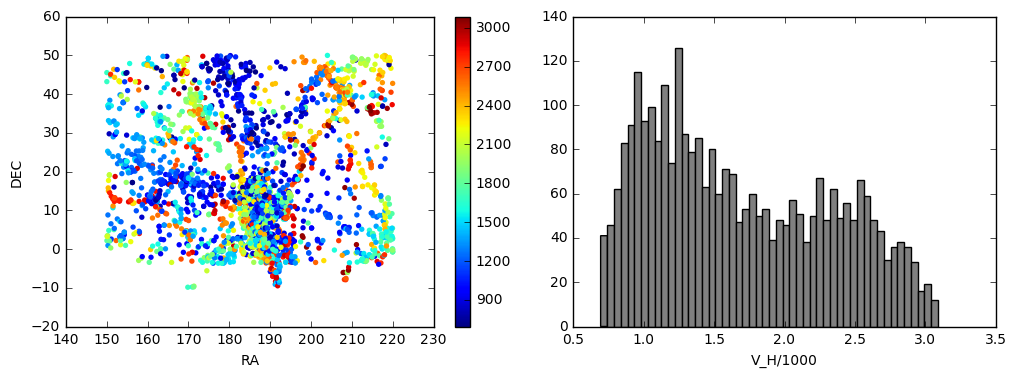

In [56]:
# plot region covered by these fits files
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(nsa.RA_1,nsa.DEC_1,c=nsa.Z*c.to('km/s'),s=15,edgecolors='None')
plt.colorbar(fraction=.08)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.subplot(1,2,2)
plt.hist(nsa.Z*c.to('km/s')/1000,bins=50,color='0.5')
plt.xlabel('V_H/1000')

In [8]:
# define NSA RA and Dec as SkyCoord
nsa_sc = SkyCoord(nsa.RA_1*u.degree, nsa.DEC_1*u.degree)


In [22]:
################################################
#####  FLOW MODEL  ###############
################################################
# using mould+00 method to correct redshifts
# described in detail in appendix A
#
# http://adsabs.harvard.edu/abs/2000ApJ...529..786M


V_H = nsa.Z*c.to('km/s')

In [21]:
# 1. correction of observed heliocentric velocity to centroid of local group
# VLG = VH - 79 cos l cos b + 296 sin l cos b - 36 sin b

V_LG = - 79.*u.km/u.second*np.cos(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) + 296.*u.km/u.second*np.sin(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) - 36.*u.km/u.second*np.sin(nsa_sc.galactic.b.radian)

In [30]:
# 2. Correction for Virgo infall
# from Mould+2000, ApJ, 529, 786
# not sure if we are using this equation exactly right
V_fid = 200.*u.km/u.second # infall of LG into Virgo?
# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
theta = np.sqrt((nsa_sc.ra.radian - Virgo.ra.radian)**2 + (nsa_sc.dec.radian - Virgo.dec.radian)**2)
# cluster radius in deg
gamma = 2.
V_a = 1035.*u.km/u.second # recession vel of Virgo from Mould+2000
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_infall = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))


In [58]:
# 3. Correction for GA infall
# from Mould+2000, ApJ, 529, 786
# not sure if we are using this equation exactly right
V_fid = 400.*u.km/u.second # infall of LG into Virgo?
# GA coordinates given by Mould+2000
GA = SkyCoord('13h20m00s', '+44d00m00s', frame='fk5',equinox='J1950.') # epoch = 1950
GA = GA.transform_to(FK5(equinox='J2000'))
theta = np.sqrt((nsa_sc.ra.radian - GA.ra.radian)**2 + (nsa_sc.dec.radian - GA.dec.radian)**2)

gamma = 2.
V_a = 4380.*u.km/u.second # recession vel of Virgo from Mould+2000
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_GA = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))


In [71]:
V_cosmic = V_H + V_LG + V_infall +V_GA

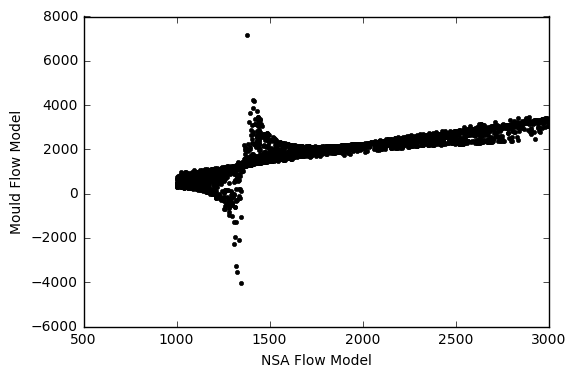

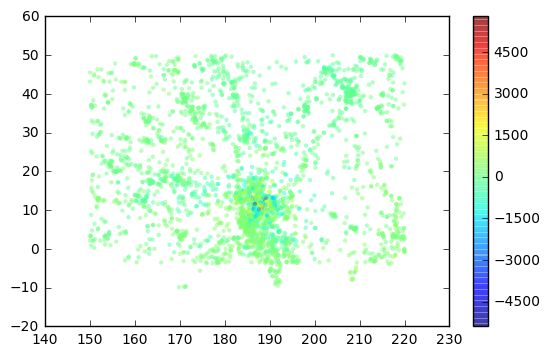

In [72]:
plt.figure()
plt.plot(nsa.ZDIST*c.to('km/s'),V_cosmic,'k.')
plt.xlabel('NSA Flow Model')
plt.ylabel('Mould Flow Model')
#plt.axvline(x=V_a.value)
plt.figure()
plt.scatter(nsa.RA_1,nsa.DEC_1,c=(V_cosmic-nsa.ZDIST*c.to('km/s')),s=10,edgecolor='None',alpha=0.5)
plt.colorbar(fraction=.08)
#plt.axis([170,210,0,20])

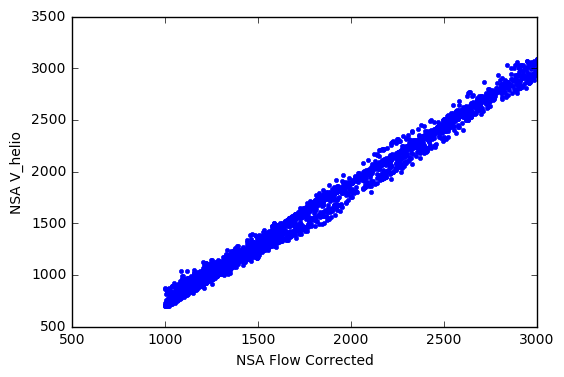

In [34]:
plt.figure()
plt.plot(nsa.ZDIST*c.to('km/s'),nsa.Z*c.to('km/s'),'b.')
plt.xlabel('NSA Flow Corrected')
plt.ylabel('NSA V_helio')

In [ ]:
# ## Tranforming to Supergalactic Coordinates##
# 
# Looking to match the plots shown in Kim+2016
# 
# https://arxiv.org/abs/1611.00437

#Plot of Virgo Cluster in galactic coordinates


distance_z = NSA.ZDIST
SGX = distance_z*c.to('km/s')/cosmo.H(0)*np.cos(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian)
SGY = distance_z*c.to('km/s')/cosmo.H(0)*np.sin(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian)
SGZ = distance_z*c.to('km/s')/cosmo.H(0)*np.sin(nsa_sc.galactic.b.radian)

# latitude and longitude of Virgo based on NED
#l = 102.93 # longitude, deg
#b = -2.73 # latitude, deg

distance_to_virgo = 16.5*u.Mpc #Mpc
SGX_Virgo = distance_to_virgo*np.cos(Virgo.l.radian)*np.cos(Virgo.b.radian)
SGY_Virgo = distance_to_virgo*np.sin(Virgo.l.radian)*np.cos(Virgo.b.radian)
SGZ_Virgo = distance_to_virgo*np.sin(Virgo.b.radian)

# difference 
DSGX = SGX - SGX_Virgo
DSGY = SGY - SGY_Virgo
DSGZ = SGZ - SGZ_Virgo
